### Drive mounted

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import glob
import tensorflow as tf


In [ ]:
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Import data

In [ ]:
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
data_dir = os.path.join(parent_dir, '/content/drive/MyDrive/Data')

img_path =  os.path.join(data_dir,'slip_img.npz')
f = np.load(img_path)

slip_grd_all = f['slip_grd_all']
print(slip_grd_all.shape)

(1800, 61, 38)


### Image visualization

Image 1 of 1800


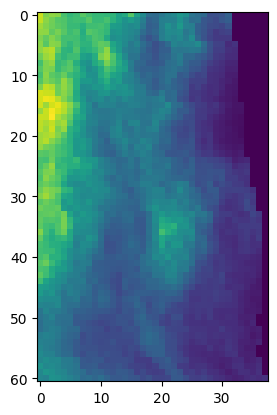

The size of the image is  (61, 38)


In [ ]:
darr = slip_grd_all[0]
print("Image 1 of 1800")
plt.imshow(darr, interpolation='nearest')
plt.show()
print("The size of the image is ", np.shape(darr))

In [ ]:
#load output
inund_path = os.path.join(data_dir, 'max_inundation.npz')
f = np.load(inund_path)

inund_px_all = f['inund_px_all']
print(inund_px_all.shape)
runup_all = f['runup_all']
print(runup_all.shape)

(4, 1800)
(4, 1800)


In [ ]:
X = slip_grd_all  # slip image
Y1 = runup_all.T  # run-up per city 1st: Viña del Mar  2nd: Valparaíso  3rd: Cartagena  4th:San Antonio

In [ ]:
Y2 = inund_px_all.T/68771 # inundation area normalized per city 1st: Viña del Mar  2nd: Valparaíso  3rd: Cartagena  4th:San Antonio

In [ ]:
Y = np.hstack((Y1,Y2))  # run-up and inundation area
Y.shape

(1800, 8)

### Data preparation

In [ ]:
#split data 80 and 20%
X_train, X_test = train_test_split(X, train_size=0.8, shuffle=True, random_state=1) # this split the slip data
Y_train, Y_test = train_test_split(Y, train_size=0.8, shuffle=True, random_state=1) # this split the run-up and inundation area data

In [ ]:
print(np.shape(X_train)) # should be (1440, 61, 38)
print(np.shape(Y_train)) # should be (1440, 8)

(1440, 61, 38)
(1440, 8)


In [ ]:
train_images = X_train
train_labels = Y_train
test_images = X_test
test_labels = Y_test

In [ ]:
max(train_images.max(), test_images.max())

52.264

In [ ]:
# Normalize the images. (between 0 and 1)
train_images = (train_images / 52.264)
test_images = (test_images / 52.264)

In [ ]:
# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (1620, 61, 38, 1)
print(test_images.shape)  # (180, 61, 38, 1)

(1440, 61, 38, 1)
(360, 61, 38, 1)


### 2D CNN model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, regularizers

L2 = 0.0001

model = models.Sequential()
model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(61, 38, 1), kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='linear', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(8))


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam' , metrics=['mean_squared_error'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 37, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 18, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 17, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 8, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 7, 32)         4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 3, 32)         0

### Training

In [ ]:
history = model.fit(train_images, train_labels, epochs=200, batch_size = 32,
                    validation_data=(test_images, test_labels))

Epoch 1/200
45/45 [==============================] - 3s 24ms/step - loss: 26.4206 - mean_squared_error: 26.3848 - val_loss: 7.3400 - val_mean_squared_error: 7.3097
Epoch 2/200
45/45 [==============================] - 1s 18ms/step - loss: 7.2429 - mean_squared_error: 7.2158 - val_loss: 6.5214 - val_mean_squared_error: 6.4967
Epoch 3/200
45/45 [==============================] - 1s 20ms/step - loss: 6.7202 - mean_squared_error: 6.6971 - val_loss: 6.0499 - val_mean_squared_error: 6.0280
Epoch 4/200
45/45 [==============================] - 1s 19ms/step - loss: 5.9973 - mean_squared_error: 5.9760 - val_loss: 5.2452 - val_mean_squared_error: 5.2246
Epoch 5/200
45/45 [==============================] - 1s 19ms/step - loss: 5.0015 - mean_squared_error: 4.9813 - val_loss: 4.3885 - val_mean_squared_error: 4.3686
Epoch 6/200
45/45 [==============================] - 1s 22ms/step - loss: 4.4214 - mean_squared_error: 4.4018 - val_loss: 4.2761 - val_mean_squared_error: 4.2567
Epoch 7/200
45/45 [=======

In [ ]:
plt.plot(history.history['mean_squared_error'], label = 'training MSE', color="k")
plt.plot(history.history['val_mean_squared_error'], label = 'validation MSE', color="gray")
plt.tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='g', grid_alpha=0.5, labelsize='x-large')
plt.grid(color='g', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('epochs')

y_star_train = model.predict(train_images)
y_star_test = model.predict(test_images)

print(np.shape(y_star_train))
print(np.shape(y_star_test))

MSE_test = np.average((y_star_test - test_labels)**2)
MSE_train = np.average((y_star_train - train_labels )**2)
print('MSE test:', MSE_test)
print('MSE train:', MSE_train)

In [ ]:
predictions = model.predict(test_images)
train_predictions = model.predict(train_images)

45/45 [==============================] - 0s 6ms/step


Text(0.5, 0.05, 'NSWE simulations[km²]')

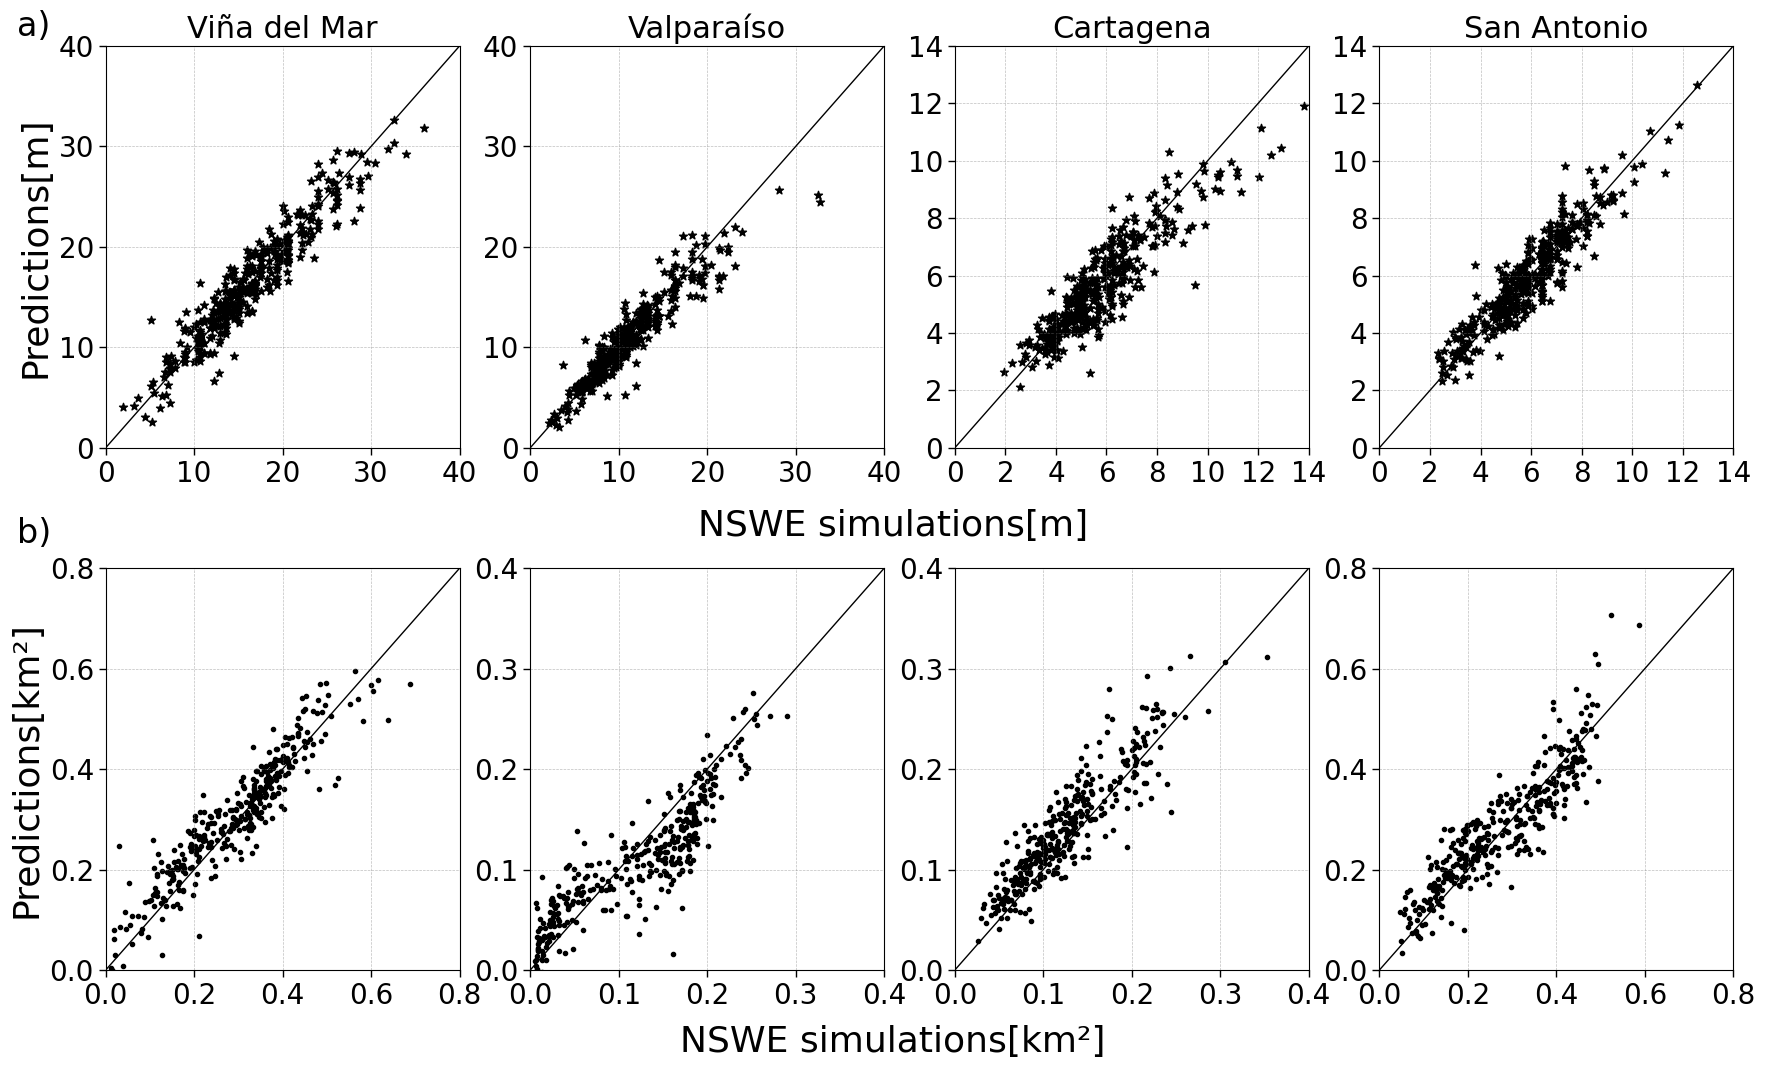

In [ ]:
from matplotlib.ticker import MaxNLocator, MultipleLocator

f, ax = plt.subplots(2, 4, figsize=(21, 12), gridspec_kw={'hspace': 0.3})

#Plot run-up

ax[0,0].scatter(test_labels[:,0], predictions[:,0], color = 'k', marker = '*', label='Run-up')
ax[0,0].set_title("Viña del Mar",fontsize = 22)
ax[0,0].set_ylabel('Predictions[m]',fontsize = 26 )
ax[0,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,0].tick_params(axis="x", labelsize=20)
ax[0,0].tick_params(axis="y", labelsize=20)
ax[0,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,0].set_xlim([0, 40])
ax[0,0].set_ylim([0, 40])
ax[0,0].axline([0,0], [1,1], color="k", linewidth=1)
ax[0,0].text(-10, 41, 'a)', fontsize = 24)
ax[0,0].text(-10, -9.5, 'b)', fontsize = 24)

ax[0,1].scatter(test_labels[:,1], predictions[:,1], color = 'k', marker = '*', label='Run-up')
ax[0,1].set_title("Valparaíso",fontsize = 22)
ax[0,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,1].tick_params(axis="x", labelsize=20)
ax[0,1].tick_params(axis="y", labelsize=20)
ax[0,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,1].set_xlim([0, 40])
ax[0,1].set_ylim([0, 40])
ax[0,1].axline([0,0], [1,1], color="k", linewidth=1)


ax[0,2].scatter(test_labels[:,2], predictions[:,2], color = 'k', marker = '*', label='Run-up')
ax[0,2].set_title("Cartagena", fontsize = 22)
ax[0,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,2].tick_params(axis="x", labelsize=20)
ax[0,2].tick_params(axis="y", labelsize=20)
ax[0,2].set_xlim([0, 14])
ax[0,2].set_ylim([0, 14])
ax[0,2].axline([0,0], [1,1], color="k", linewidth=1)
ax[0,2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,2].yaxis.set_major_locator(MaxNLocator(integer=True))


ax[0,3].scatter(test_labels[:,3], predictions[:,3], color = 'k', marker = '*', label='Run-up')
ax[0,3].set_title("San Antonio", fontsize = 22)
ax[0,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,3].tick_params(axis="x", labelsize=20)
ax[0,3].tick_params(axis="y", labelsize=20)
ax[0,3].set_xlim([0, 14])
ax[0,3].set_ylim([0, 14])
ax[0,3].axline([0,0], [1,1], color="k", linewidth=1)
ax[0,3].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,3].yaxis.set_major_locator(MaxNLocator(integer=True))



f.text(0.5, 0.48, 'NSWE simulations[m]', ha='center', va='center', fontsize=26)


#Plot inundation area

ax[1,0].scatter(test_labels[:,4]*68771*1e-5, predictions[:,4]*68771*1e-5, color = 'k', marker = '.', label='Inundation area')
ax[1,0].set_ylabel('Predictions[km²]',fontsize = 26 )
ax[1,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,0].tick_params(axis="x", labelsize=20)
ax[1,0].tick_params(axis="y", labelsize=20)
ax[1,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,0].set_xlim([0, .8])
ax[1,0].set_ylim([0, .8])
ax[1,0].axline([0,0], [1,1], color="k", linewidth=1)


ax[1,1].scatter(test_labels[:,5]*68771*1e-5, predictions[:,5]*68771*1e-5, color = 'k', marker = '.', label='Inundation area')
ax[1,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,1].tick_params(axis="x", labelsize=20)
ax[1,1].tick_params(axis="y", labelsize=20)
ax[1,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,1].set_xlim([0, .4])
ax[1,1].set_ylim([0, .4])
ax[1,1].axline([0,0], [1,1], color="k", linewidth=1)

ax[1,2].scatter(test_labels[:,6]*68771*1e-5, predictions[:,6]*68771*1e-5, color = 'k', marker = '.', label='Inundation area')
ax[1,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,2].tick_params(axis="x", labelsize=20)
ax[1,2].tick_params(axis="y", labelsize=20)
ax[1,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,2].set_xlim([0, .4])
ax[1,2].set_ylim([0, .4])
ax[1,2].axline([0,0], [1,1], color="k", linewidth=1)

ax[1,3].scatter(test_labels[:,7]*68771*1e-5, predictions[:,7]*68771*1e-5, color = 'k', marker = '.', label='Inundation area')
ax[1,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,3].tick_params(axis="x", labelsize=20)
ax[1,3].tick_params(axis="y", labelsize=20)
ax[1,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,3].set_xlim([0, .8])
ax[1,3].set_ylim([0, .8])
ax[1,3].axline([0,0], [1,1], color="k", linewidth=1)


f.text(0.5, 0.05, 'NSWE simulations[km²]', ha='center', va='center', fontsize=26)


## Uncertainty quantification - Ensemble model (Osband et al., 2018)
### Prior and training model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Lambda, add,  Activation, concatenate, Input, Embedding
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.losses import MeanSquaredError
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
# prior network output

# shared input of the network
net_input = Input(shape=(61, 38, 1),name='input')

# let us build the prior network
L2 = 0.0001
prior_net = Sequential([
  Conv2D(16, (2, 2),  activation='relu', input_shape=(61, 38, 1),kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D(pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Flatten(),
  Dense(96, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
], name='prior_net')(net_input)

prior_output = Dense(8,'linear',kernel_initializer='glorot_normal',
                     trainable=False, name='prior_out')(prior_net)


# compiling a model for this network
prior_model = Model(inputs=net_input, outputs=prior_output)


In [ ]:
# adding trainable network

# trainable network body

trainable_net = Sequential([
  Conv2D(16, (2, 2),  activation='relu', input_shape=(61, 38, 1),kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D(pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Flatten(),
  Dense(96, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu',  kernel_regularizer=regularizers.l2(L2)),
], name='trainable_net')(net_input)

# trainable network output

trainable_output = Dense(8,'linear', name='trainable_out')(trainable_net)

# using a lambda layer so we can control the weight (beta) of the prior network

prior_scale = Lambda(lambda x: x * 30, name='prior_scale')(prior_output) #beta = sd*5=12091*5

# lastly, we use a add layer to add both networks together and get Q

add_output = add([trainable_output, prior_scale], name='add')

# defining the model
model = Model(inputs=net_input, outputs=add_output)

trainable_model = Model(inputs=model.input, outputs=model.get_layer('trainable_out').output)

In [ ]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 61, 38, 1)]  0           []                               
                                                                                                  
 prior_net (Sequential)         (None, 64)           76208       ['input[0][0]']                  
                                                                                                  
 trainable_net (Sequential)     (None, 64)           76208       ['input[0][0]']                  
                                                                                                  
 prior_out (Dense)              (None, 8)            520         ['prior_net[0][0]']              
                                                                                           

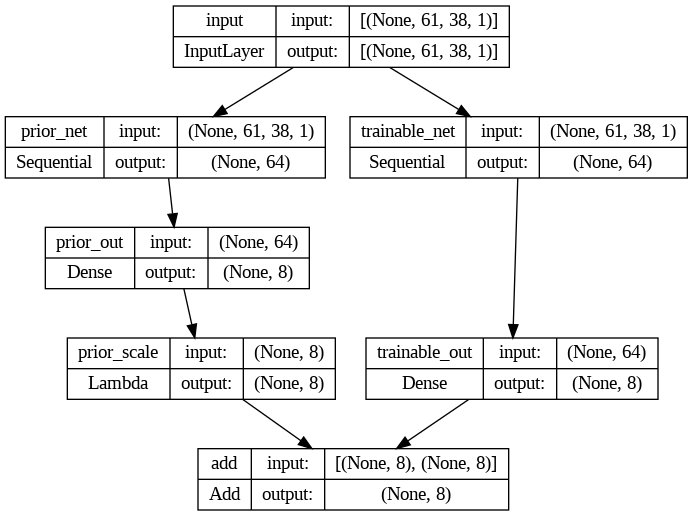

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

### Running 30 times the NN - ensemble of 30 NN (the test for vary the number of trained neural networks is in M2)

In [ ]:
#running n NNs

nsims=30
prior_pred = prior_model.predict(test_images)

predict= np.zeros([360,8,nsims])
train_predict = np.zeros([360,8,nsims])


for i in range(nsims):
  model = Model(inputs=net_input, outputs=add_output)
  trainable_model = Model(inputs=model.input, outputs=model.get_layer('trainable_out').output)
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  history = model.fit(train_images, train_labels, epochs=200, batch_size = 32,validation_data=(test_images, test_labels))

  predict[:,:,i] = model.predict(test_images)
  train_predict[:,:,i] = trainable_model(test_images)



Streaming output truncated to the last 5000 lines.
Epoch 108/200
45/45 [==============================] - 0s 8ms/step - loss: 0.0686 - mean_squared_error: 0.0048 - val_loss: 1.2943 - val_mean_squared_error: 1.2305
Epoch 109/200
45/45 [==============================] - 0s 8ms/step - loss: 0.0698 - mean_squared_error: 0.0061 - val_loss: 1.2973 - val_mean_squared_error: 1.2336
Epoch 110/200
45/45 [==============================] - 0s 8ms/step - loss: 0.0717 - mean_squared_error: 0.0080 - val_loss: 1.3026 - val_mean_squared_error: 1.2389
Epoch 111/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0704 - mean_squared_error: 0.0067 - val_loss: 1.3004 - val_mean_squared_error: 1.2367
Epoch 112/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0700 - mean_squared_error: 0.0063 - val_loss: 1.2933 - val_mean_squared_error: 1.2296
Epoch 113/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0706 - mean_squared_error: 0.0069 - val_loss: 1.2864 - va

In [ ]:
#save variables in .npy
np.save('../content/drive/MyDrive/Data/predict_slip_data1_bayesian.npy',predict)
np.save('../content/drive/MyDrive/Data/train_slip_data1_bayesian_predict.npy',train_predict)
np.save('../content/drive/MyDrive/Data/prior_slip_data1_bayesian_predict.npy',prior_pred)

In [ ]:
#load variables
predict=np.load('../content/drive/MyDrive/Data/predict_slip_data1_bayesian.npy')
train_predict=np.load('../content/drive/MyDrive/Data/train_slip_data1_bayesian_predict.npy')
prior_pred=np.load('../content/drive/MyDrive/Data/prior_slip_data1_bayesian_predict.npy')
print(predict.shape)
print(train_predict.shape)
print(prior_pred.shape)

(360, 8, 30)
(360, 8, 30)
(360, 8)


In [ ]:
#standard deviation and mean
means=np.mean(predict[:,0,:], axis=1)
stddev=np.std(predict[:,0,:],axis=1,ddof=1)
print(means.shape)
print(stddev.shape)
print(np.max(stddev))

(360,)
(360,)
1.3642285101472953


In [ ]:
x = test_labels[:,0]
y= means

### Plots mean of predictions vs real data

In [ ]:
y=x
y_ihat=y
y_bar=np.mean(y)


SSR=0
SST=0

for i in range(len(x)):
  SSR=SSR+(y[i]-y_ihat[i])**2
  SST=SST+(y[i]-y_bar)**2

Rsquared = 1- (SSR/SST)
print(Rsquared)

0.8783215753731612


### Plot standard deviation

<ipython-input-24-150ba83beda6>:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb=plt.colorbar(mapper)


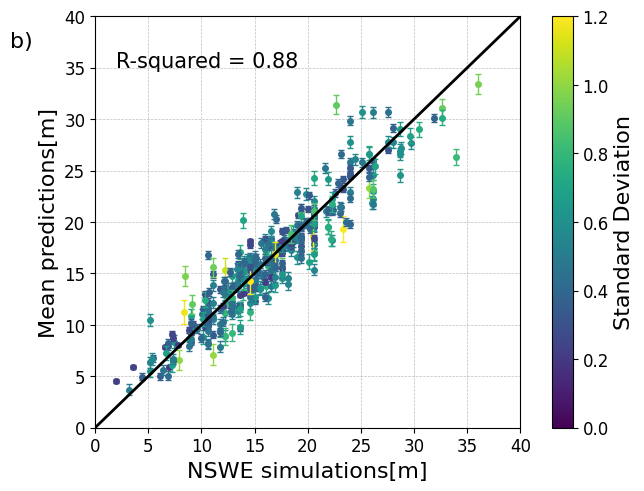

In [ ]:
yerr = stddev
fig, ax = plt.subplots(layout='constrained')

sc=plt.scatter(x,y, s=0.1, c=yerr)

#convert time to a color tuple using the colormap used for scatter
import matplotlib
import matplotlib.cm as cm
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.2, clip=True)

mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
time_color = np.array([(mapper.to_rgba(v)) for v in yerr])
cb=plt.colorbar(mapper)
cb.set_label("Standard Deviation", fontsize = 16)
cb.ax.tick_params(labelsize=12)
#loop over each data point to plot
for X, Y, e, color in zip(x, y, yerr, time_color):
    plt.plot(X, Y, 'o', color=color,markersize=4)
    plt.errorbar(X, Y, e, lw=1, capsize=2, color=color)

#sns.regplot(data=df,x="Real data", y="Mean predictions", color="black", scatter=False, label= "Confidence 95%", ax=ax)
plt.text (-8,37, "b)", fontsize= 16)
plt.xlabel('NSWE simulations[m]',fontsize = 16)
plt.ylabel('Mean predictions[m]',fontsize = 16 )
plt.axline([0,0], [1,1], color="k", linewidth=2)
plt.text(2, 35, 'R-squared = %0.2f' % Rsquared, fontsize= 15)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
#plt.title("Viña del mar", size=18)
plt.xlim([0, 40])
plt.ylim([0, 40])
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.legend(fontsize=10)

### Distribution of residuals

-4.245210629417354
4.048839268665036


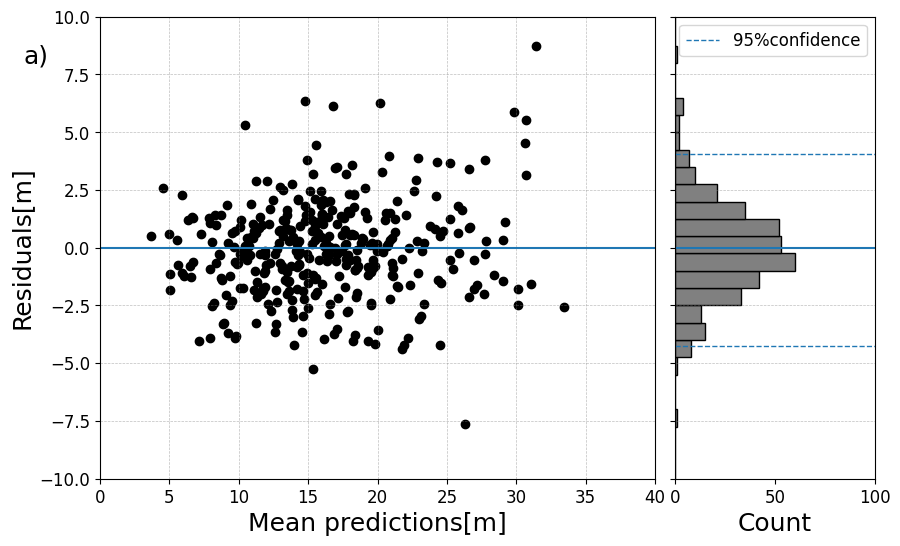

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

residual = y-x

fig, ax = plt.subplots(figsize=(10, 6))

# the scatter plot:
ax.scatter(y, residual, color='k')
ax.set_xlabel('Mean predictions[m]',fontsize = 18)
ax.set_ylabel('Residuals[m]',fontsize = 18 )
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, linewidth=1.5)
plt.xlim([0, 40])
plt.ylim([-10, 10])
plt.text (-5.5,8, "a)", fontsize= 18)

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histy = divider.append_axes("right",2, pad=0.2, sharey=ax)

# make some labels invisible
ax_histy.yaxis.set_tick_params(labelleft=False)
w=0.75
ax_histy.hist(residual, bins=np.arange(-10, 10 + w, w), edgecolor = 'black',orientation='horizontal', color='gray')
ax_histy.set_xlabel('Count',fontsize = 18)
ax_histy.tick_params(axis="x", labelsize=12)
ax_histy.set_xlim([0, 100])
ax_histy.grid(color='gray', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, linewidth=1.5)

conf=mu-2*std
conf_=mu+2*std
print(conf)
print(conf_)
plt.axhline(y=conf, linestyle='--', linewidth=1, label="95%confidence")
plt.axhline(y=conf_, linestyle='--', linewidth=1)
ax_histy.legend(loc='best',fontsize = "large")
plt.show()